In [1]:
!ls

LICENSE  README.md  dataset_preparation.py  preprocessing.ipynb  src


In [2]:
!git clone https://github.com/salesforce/WikiSQL ../wiki-sql

Cloning into '../wiki-sql'...
remote: Enumerating objects: 382, done.
remote: Counting objects: 100% (141/141), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 382 (delta 85), reused 110 (delta 56), pack-reused 241
Receiving objects: 100% (382/382), 50.72 MiB | 19.60 MiB/s, done.
Resolving deltas: 100% (206/206), done.


In [9]:
# install libraries
!pip install -r ../wiki-sql/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 kB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 86.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 610.9/610.9 kB 73.5 MB/s eta 0:00:00
  Created wheel for openpyxl: filename=openpyxl-2.4.11-py2.py3-none-any.whl size=222821 sha256=3b2ace0da527a7ca2ae54443e880d8d71129df6cc07e4e5e7c74f7e849229bed
  Stored in directory: /home/ando_cavallari/.cache/pip/wheels/26/0a/ac/df3ec90b66c333ad3d7c4d314b131f61faceba11b3891ce500
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=8dab17395af02c8510efbbc0acc14f5be93067ea937fbb826681400b66452bcc
  Stored in directory: /home/ando_cavallari/.cache/pip/wheels/4e/29/5e/e5f6f558e24e0d70f6808e3e8fdaf2c04ff597233098afc550
Successfully built openpyxl docopt
tar

In [14]:
# extract data in the current project structure
!tar -xvf ../wiki-sql/data.tar.bz2

data/
data/train.jsonl
data/test.tables.jsonl
data/test.db
data/dev.tables.jsonl
data/dev.db
data/test.jsonl
data/train.tables.jsonl
data/train.db
data/dev.jsonl


Inspect content test dataset

In [3]:
!tail data/test.jsonl

{"phase": 2, "table_id": "2-12962193-3", "question": "what is the top-5 when the tournament is totals and the top-25 is more than 4?", "sql": {"sel": 2, "conds": [[0, 0, "totals"], [3, 1, 4]], "agg": 5}}
{"phase": 2, "table_id": "2-12962193-3", "question": "what is the average number of events when the top-5 is less than 1 and top 25 more than 1", "sql": {"sel": 4, "conds": [[2, 2, 1], [3, 1, 1]], "agg": 5}}
{"phase": 2, "table_id": "2-12962193-3", "question": "what is the highest top-5 when the top-25 is less than 4, cuts made is more than 3 and wins is 0?", "sql": {"sel": 2, "conds": [[3, 2, 4], [5, 1, 3], [1, 2, 0]], "agg": 1}}
{"phase": 2, "table_id": "2-12962193-3", "question": "what is the total number of times the tournament was pga championship and evens is less than 4?", "sql": {"sel": 2, "conds": [[0, 0, "pga championship"], [4, 2, 4]], "agg": 3}}
{"phase": 2, "table_id": "2-1226335-1", "question": "What year did Elf Team Tyrrell have 34 points?", "sql": {"sel": 0, "conds": [

Count lines in test set

In [4]:
!wc -l data/test.jsonl

15878 data/test.jsonl


# PreProcessing
1. read and parse tables
2. read and parse queries
3. generate sql-text based on table and query index
4. generate generate graph from sql based on paper instruction

In [8]:
%load_ext autoreload
%autoreload 2

In [23]:
import networkx as nx
from pathlib import Path
import json
from src.utils.table import Table
from src.utils.query import Query
data_base_path = Path("data")

In [12]:
def parse_tables(dataset_name_: str) -> dict[str, Table]:
    # read table dataset and parse in into the Table data structure
    table_path_ = data_base_path.joinpath(f"{dataset_name_}.tables.jsonl")
    collector = dict()
    with open(table_path_.as_posix(), "r") as f:
        for line in f.readlines():
            obj = json.loads(line)
            obj["table_id"] = obj["id"].strip()
            table = Table(**obj)
            collector[table.table_id] = table
    return collector

tables = parse_tables("test")
tables

{'1-10015132-16': Table: 1-10015132-16
 Caption: R
 Player                No.     Nationality    Position        Years in Toronto    School/Club Team
 --------------------  ------  -------------  --------------  ------------------  ------------------
 Aleksandar Radojević  25      Serbia         Center          1999-2000           Barton CC (KS)
 Shawn Respert         31      United States  Guard           1997-98             Michigan State
 Quentin Richardson    N/A     United States  Forward         2013-present        DePaul
 Alvin Robertson       7, 21   United States  Guard           1995-96             Arkansas
 Carlos Rogers         33, 34  United States  Forward-Center  1995-98             Tennessee State
 Roy Rogers            9       United States  Forward         1998                Alabama
 Jalen Rose            5       United States  Guard-Forward   2003-06             Michigan
 Terrence Ross         31      United States  Guard           2012-present        Washington,
 '

In [13]:
len(tables)

5230

In [15]:
dataset_name = "test"


def parse_queries(
    dataset_name_: str,
    tables_: dict[str, Table],
) -> list[Query]:
    # parse queries and subsitute
    dataset_path_ = data_base_path.joinpath(f"{dataset_name_}.jsonl")
    collector = []

    with open(dataset_path_.as_posix(), "r") as f:
        for line in f.readlines():
            obj = json.loads(line)
            sql = obj["sql"]

            # yapf: disable
            # check object refer to known table
            assert obj["table_id"] in tables_, "sql refer to unknown table \n {}".format(obj)
            # check if there are entires containing multiple queries
            assert isinstance(sql, dict), "multi query: {}".format(sql)
            # check if there are queries with multiple select contition
            assert isinstance(sql["sel"], int), "mulitple select condition: {}".format(sql)
            # check if there are queries with multiple agg contition
            assert isinstance(sql["agg"], int), "mulitple aggregate condition: {}".format(sql)
            # yapf: enable

            sql["table_id"] = obj["table_id"]
            query = Query.from_dict(
                sql,
                table=tables_[sql["table_id"]],
            )

            collector.append(query)
    return collector


queries = parse_queries(
    "test",
    tables,
)

len(queries)

15878

query are parsed !

Note: 
 - test set has only 15878 example instead of the 17284! 
 - only AND locical operator, sql conditions are not always joined by AND. How to detect them
 ```
 {
	'phase': 1,
	'table_id': '1-12194021-1',
	'question': 'In womens doubles and mens singles, what years did Arvind Bhat or Valiyaveetil Diju Jwala Gutta win?',
	'sql': {
		'sel': 4,
		'conds': [
			[1, 0, 'Arvind Bhat'],
			[5, 0, 'Valiyaveetil Diju Jwala Gutta']
		],
		'agg': 0
	}
}
```

Clarify


In [19]:
obj = {
    'phase':
        1,
    'table_id':
        '1-12194021-1',
    'question':
        'In womens doubles and mens singles, what years did Arvind Bhat or Valiyaveetil Diju Jwala Gutta win?',
    'sql': {
        'sel': 4,
        'conds': [[1, 0, 'Arvind Bhat'],
                  [5, 0, 'Valiyaveetil Diju Jwala Gutta']],
        'agg': 0
    }
}
sql = obj["sql"]
sql["table_id"] = obj["table_id"]
query = Query.from_dict(
    sql,
    table=tables[sql["table_id"]],
)
query

SELECT Womens doubles FROM 1-12194021-1 WHERE Mens singles = arvind bhat AND Mixed doubles = valiyaveetil diju jwala gutta

In [20]:
tables["1-12194021-1"]

Table: 1-12194021-1
Caption: 21st century
  Season  Mens singles        Womens singles    Mens doubles                     Womens doubles                 Mixed doubles
--------  ------------------  ----------------  -------------------------------  -----------------------------  --------------------------------
    2000  Pullela Gopichand   Aparna Popat      Vincent Lobo Jaseel P. Ismail    Jwala Gutta Shruti Kurian      Vincent Lobo Madhumita Bisht
    2001  Abhinn Shyam Gupta  Aparna Popat      Sanave Thomas Valiyaveetil Diju  K. Neelima Chowdary D. Swetha  Markose Bristow Madhumita Bisht
    2002  Abhinn Shyam Gupta  Aparna Popat      Markose Bristow Rupesh Kumar     Jwala Gutta Shruti Kurian      Jaseel P. Ismail Manjusha Kanwar
    2003  Chetan Anand        Aparna Popat      Markose Bristow Rupesh Kumar     Jwala Gutta Shruti Kurian      Pullela Gopichand Jwala Gutta
    2004  Anup Sridhar        Aparna Popat      Rupesh Kumar Sanave Thomas       Jwala Gutta Shruti Kurian      Mar

In [22]:
sorted(tables["1-12194021-1"].header)

['Mens doubles',
 'Mens singles',
 'Mixed doubles',
 'Season',
 'Womens doubles',
 'Womens singles']

In [142]:
vars(query), query, obj

({'sel_op': 'Year',
  'agg_op': 'SUM',
  'conditions': [Condition(column='Entrant', operator='=', condition='elf team tyrrell'),
   Condition(column='Points', operator='=', condition='39'),
   Condition(column='Chassis', operator='=', condition='tyrrell 007')],
  'ordered': False,
  'table_id': '2-1226335-1'},
 SELECT SUM Year FROM 2-1226335-1 WHERE Entrant = elf team tyrrell AND Points = 39 AND Chassis = tyrrell 007,
 {'phase': 2,
  'table_id': '2-1226335-1',
  'question': 'What year did Elf Team Tyrrell have 39 points and a Tyrrell 007 Chassis?',
  'sql': {'sel': 0,
   'conds': [[1, 0, 'elf team tyrrell'], [4, 0, '39'], [2, 0, 'tyrrell 007']],
   'agg': 4,
   'table_id': '2-1226335-1'}})

In [147]:
tables["2-18994323-12"].header

['Athlete',
 'Event',
 'Round of 32',
 'Round of 16',
 'Quarterfinals',
 'Semifinals',
 'Finals',
 'Rank']

In [130]:
queries[0]

SELECT Nationality FROM 1-10015132-16 WHERE Player = terrence ross

In [123]:
str(queries[0]),re.sub(r"\s+", " ", str(queries[0]))

('SELECT  Nationality FROM 1-10015132-16 WHERE Player = terrence ross',
 'SELECT Nationality FROM 1-10015132-16 WHERE Player = terrence ross')

# Query to Graph

1. create join vocabulary for text and node ids. In this way a single embedding is needed
2. add special tokens like `SELECT`, `AND`, `PAD`, `SOS`, `EOS`. the vocabilary should be defined only on the train set, this OOV token should be present
3. create sql-to-graph function
4. create sql-to-ids function
5. process train set in raw format
6. preprocess dataset accordign to PyG Data format. As the graph is directed, the bw embedding is obtained by adding "fake reverse edges". this will play well with PyG MessagePassing architecture in the update function as the nodes to scatter over are always the same.



In [85]:
from src.utils.common import EntityToId

SELECT = "SELECT"
AND = "AND"
WHERE = "WHERE"

PAD = "PAD"
SOS = "SOS"
EOS = "EOS"
OOV = "OOV"

NAME_2_ID = EntityToId()
# add SQL tokens
NAME_2_ID.add_entity(PAD)
NAME_2_ID.add_entity(SOS)
NAME_2_ID.add_entity(EOS)
NAME_2_ID.add_entity(OOV)
NAME_2_ID.add_entity(SELECT)
NAME_2_ID.add_entity(AND)
NAME_2_ID.add_entity(WHERE)

NAME_2_ID, NAME_2_ID.inverse

({'PAD': 0, 'SOS': 1, 'EOS': 2, 'OOV': 3, 'SELECT': 4, 'AND': 5, 'WHERE': 6},
 {0: 'PAD', 1: 'SOS', 2: 'EOS', 3: 'OOV', 4: 'SELECT', 5: 'AND', 6: 'WHERE'})

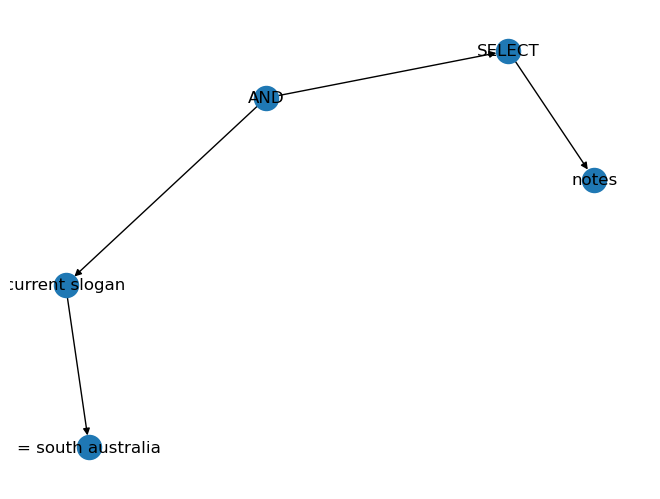

In [116]:
def get_graph(
    query_: Query,
    entity_mapper: EntityToId,
) -> nx.Graph:
    # convert query to graph.
    # convention: SQL token uppercased, remaning entities lowercased
    g = nx.DiGraph()
    # non SQL entitie lowercased
    sel_op = query_.sel_op.lower()
    # add select to column edge
    g.add_edge(SELECT, sel_op)
    entity_mapper.add_entity(sel_op)

    # add aggregator to column node, SQL operators uppercased
    if not (query_.agg_op == "" or query_.agg_op is None):
        g.add_edge(query_.agg_op.upper(), sel_op)
        entity_mapper.add_entity(query_.agg_op.upper())

    if len(query_.conditions) > 0:
        g.add_edge(AND, SELECT)
        for condition in query_.conditions:
            column_name = condition.column.lower()
            condition_op = "{} {}".format(
                condition.operator,
                condition.condition,
            ).lower()
            g.add_edge(AND, column_name)
            g.add_edge(column_name, condition_op)
            entity_mapper.add_entity(column_name)
            entity_mapper.add_entity(condition_op)

    return g

g = get_graph(queries[0], NAME_2_ID)

import matplotlib.pyplot as plt

nx.draw(g, with_labels=True)
plt.show()

In [98]:
def get_sql_tokens(
    query_: Query,
    entity_mapper: EntityToId,
    force_in_vocab: bool = True,
) -> tuple[list[str], list[int]]:
    # convert query to sql tokens and tokens ids.
    # param force_in_vocab: raise an error if a token is not present in NAME_2_ID vocabulary
    # convention: SQL token uppercased, remaning entities lowercased
    tokens = [SELECT]
    # add aggregator to column node
    if not (query_.agg_op == "" or query_.agg_op is None):
        tokens.append(query_.agg_op.upper())
    # add column name
    tokens.append(query_.sel_op.lower())
    # FROM clauses is skipped in the paper
    tokens.append("WHERE")

    for condition in query_.conditions:
        column_name = condition.column.lower()
        condition_op = "{} {}".format(
            condition.operator,
            condition.condition,
        ).lower()
        tokens.append(column_name)
        tokens.append(condition_op)
        tokens.append(AND)

    # remove last AND
    tokens = tokens[:-1]
    if force_in_vocab:
        tokens_ids = [entity_mapper[t] for t in tokens]
    else:
        tokens_ids = [entity_mapper.get(t, entity_mapper[OOV]) for t in tokens]
    # handle OOV values
    return tokens, tokens_ids

In [99]:
tokens, tokens_id = get_sql_tokens(queries[0], NAME_2_ID)
tokens, tokens_id, " ".join([NAME_2_ID.inverse[id_] for id_ in tokens_id])

(['SELECT', 'notes', 'WHERE', 'current slogan', '= south australia'],
 [4, 7, 6, 8, 9],
 'SELECT notes WHERE current slogan = south australia')

In [90]:
tokens, tokens_id = get_sql_tokens(query, NAME_2_ID, False)
tokens, tokens_id, " ".join([NAME_2_ID.inverse[id_] for id_ in tokens_id])

(['SELECT',
  'nationality',
  'WHERE',
  'mens singles',
  '= arvind bhat',
  'AND',
  'mixed doubles',
  '= valiyaveetil diju jwala gutta'],
 [4, 7, 6, 3, 3, 5, 3, 3],
 'SELECT nationality WHERE OOV OOV AND OOV OOV')

# Raw processing of train dataset


In [128]:
import pickle

dataset_name = "train"
dest_folder = "wiki"
tables = parse_tables(dataset_name)
queries = parse_queries(dataset_name, tables)

print("table: {} \t | \t queries: {}".format(len(tables), len(queries)))

NAME_2_ID = EntityToId()
# add SQL tokens
NAME_2_ID.add_entity(PAD)
NAME_2_ID.add_entity(SOS)
NAME_2_ID.add_entity(EOS)
NAME_2_ID.add_entity(OOV)
NAME_2_ID.add_entity(SELECT)
NAME_2_ID.add_entity(AND)
NAME_2_ID.add_entity(WHERE)

print("generate graphs")
graphs = []
query_tokens = []
query_tokens_ids = []

for q_idx, query in enumerate(queries):
    g = get_graph(query, NAME_2_ID)
    tokens, tokens_id = get_sql_tokens(query, NAME_2_ID, True)

    assert g.number_of_nodes() <= len(tokens)
    assert len(tokens_id) == len(tokens)
    
    graphs.append(g)
    query_tokens.append(tokens)
    query_tokens_ids.append(tokens_id)

NAME_2_ID.froze()

output_folder = data_base_path.joinpath(
    "wiki",
    "raw",
)
output_folder.mkdir(parents=True, exist_ok=True,)

# yapf: disable
with open(
        output_folder.joinpath(
            "{}_queries.bin".format(dataset_name)
        ).as_posix(),
        "wb",
) as w:
    pickle.dump(queries, w)

with open(
        output_folder.joinpath(
            "{}_graphs.bin".format(dataset_name)
        ).as_posix(),
        "wb",
) as w:
    pickle.dump(graphs, w)

with open(
        output_folder.joinpath(
            "{}query_tokens.bin".format(dataset_name)
        ).as_posix(),
        "wb",
) as w:
    pickle.dump(query_tokens, w)

with open(
        output_folder.joinpath(
            "{}query_tokens_ids.bin".format(dataset_name)
        ).as_posix(),
        "wb",
) as w:
    pickle.dump(query_tokens_ids, w)

with open(
    data_base_path.joinpath(
        "wiki",
        "entity_2_id.bin",
    ).as_posix(),
    "wb",
) as w:
    pickle.dump(NAME_2_ID, w)
# yapf: enable


table: 18585 	 | 	 queries: 56355
generate graphs


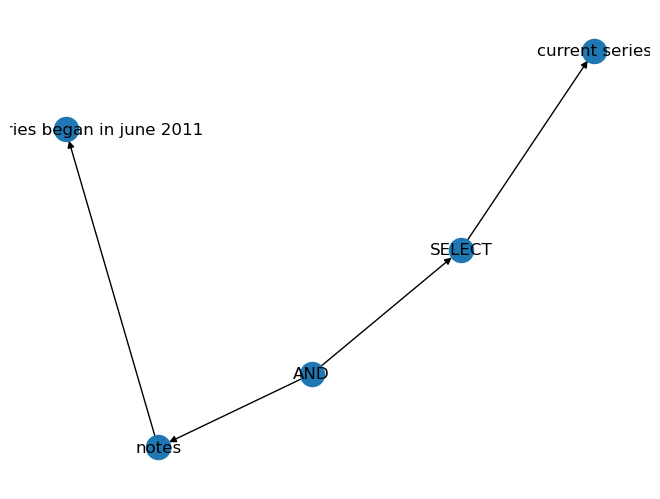

In [119]:
with open(
    output_folder.joinpath("{}_graphs.bin".format(dataset_name)).as_posix(),
    "rb",
) as file:
    gs = pickle.load(file)

import matplotlib.pyplot as plt

nx.draw(gs[1], with_labels=True)
plt.show()

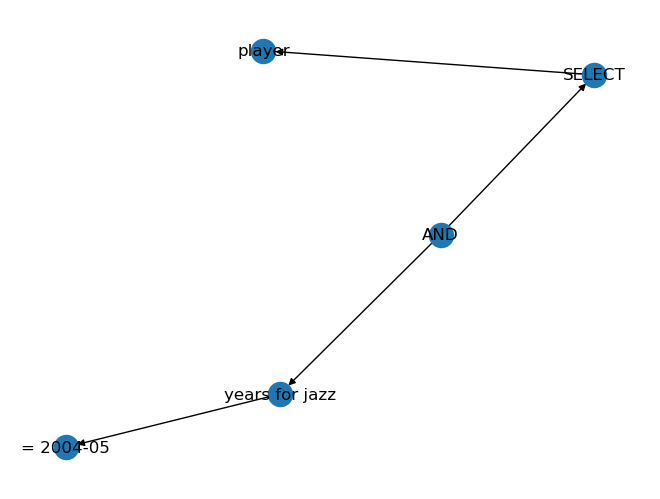

In [127]:
nx.draw(gs[1006], with_labels=True)
plt.show()


In [115]:
tokens, tokens_id, g.number_of_nodes()

(['SELECT',
  'COUNT',
  'fleet series (quantity)',
  'WHERE',
  'fuel propulsion',
  '= cng'],
 [4, 17, 16, 6, 18, 19],
 7)

In [173]:
g = nx.DiGraph()
q = queries[0]

g.add_edge("SELECT", q.sel_op)

if not (q.agg_op == "" or q.add_op is None):
    g.add_edge(q.agg_op.upper(), q.sel_op)


if len(q.conditions) > 0:
    g.add_edge("AND", "SELECT")
    for condition in q.conditions:
        g.add_edge("AND", condition.column.lower())

        g.add_edge(condition.column.lower(), "{} {}".format(
            condition.operator,
            condition.condition,
        ))

for node in g.nodes:
    if node not in node_name_2_node_id:
        node_name_2_node_id[node] = len(node_name_2_node_id)

dict((node, node_name_2_node_id[node]) for node in g.nodes)


{'SELECT': 0, 'Nationality': 2, 'AND': 1, 'player': 3, '= terrence ross': 4}

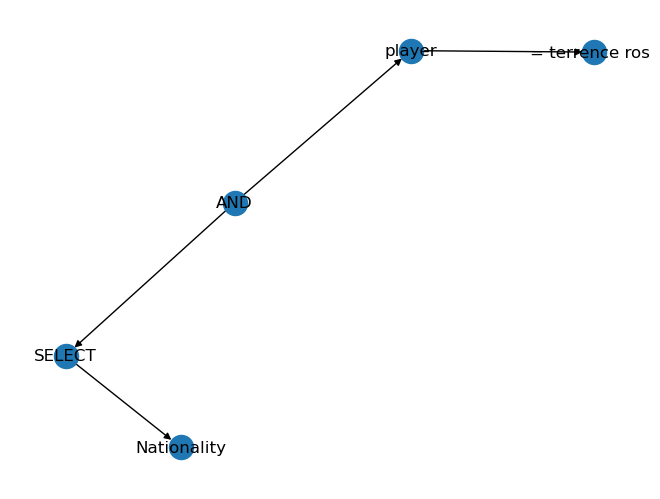

In [152]:
import matplotlib.pyplot as plt

nx.draw(g, with_labels=True)
plt.show()

To clarify:
- how to represent where clauses with single condition ?

In [239]:
g.in_edges

InEdgeView([('AND', 'SELECT'), ('SELECT', 'Nationality'), ('AND', 'player'), ('player', '= terrence ross')])

In [240]:
g.out_edges

OutEdgeView([('SELECT', 'Nationality'), ('AND', 'SELECT'), ('AND', 'player'), ('player', '= terrence ross')])

In [241]:
g.edges

OutEdgeView([('SELECT', 'Nationality'), ('AND', 'SELECT'), ('AND', 'player'), ('player', '= terrence ross')])

In [294]:
import torch
from torch_scatter import scatter
from torch_geometric.data import Data

# convert str labels to int based on g.nodes order
g_num = nx.convert_node_labels_to_integers(g)
# get out_edges
edges = list(g_num.out_edges)
fw_edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
# get backwards edges, just create fake reverse edges
bw_edge_index = fw_edge_index[[1, 0]].contiguous()

data_ = Data(
    x=torch.tensor([node_name_2_node_id[n] for n in g.nodes()]),
    edge_index=fw_edge_index,
    # add reversed paths
    bw_edge_index=bw_edge_index,
    # miss y
)

data_

Data(x=[5], edge_index=[2, 4], bw_edge_index=[2, 4])

In [248]:
import torch

emb = torch.nn.Embedding(10, 5)
emb.weight.data = torch.tensor([[float(i)] * 5 for i in range(10)])
emb.weight

Parameter containing:
tensor([[0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1.],
        [2., 2., 2., 2., 2.],
        [3., 3., 3., 3., 3.],
        [4., 4., 4., 4., 4.],
        [5., 5., 5., 5., 5.],
        [6., 6., 6., 6., 6.],
        [7., 7., 7., 7., 7.],
        [8., 8., 8., 8., 8.],
        [9., 9., 9., 9., 9.]], requires_grad=True)

In [263]:
data_.x, data_.edge_index

(tensor([0, 2, 1, 3, 4]),
 tensor([[0, 2, 2, 3],
         [1, 0, 3, 4]]))

In [262]:
node_emb = emb(data_.x)
node_emb

tensor([[0., 0., 0., 0., 0.],
        [2., 2., 2., 2., 2.],
        [1., 1., 1., 1., 1.],
        [3., 3., 3., 3., 3.],
        [4., 4., 4., 4., 4.]], grad_fn=<EmbeddingBackward0>)

In [295]:
data_.edge_index, data_.bw_edge_index

(tensor([[0, 2, 2, 3],
         [1, 0, 3, 4]]),
 tensor([[1, 0, 3, 4],
         [0, 2, 2, 3]]))

In [296]:
# edge emb
fw_edge_emb = node_emb[data_.edge_index]
bw_edge_emb = node_emb[data_.bw_edge_index]
fw_edge_emb, bw_edge_emb

(tensor([[[0., 0., 0., 0., 0.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [3., 3., 3., 3., 3.]],
 
         [[2., 2., 2., 2., 2.],
          [0., 0., 0., 0., 0.],
          [3., 3., 3., 3., 3.],
          [4., 4., 4., 4., 4.]]], grad_fn=<IndexBackward0>),
 tensor([[[2., 2., 2., 2., 2.],
          [0., 0., 0., 0., 0.],
          [3., 3., 3., 3., 3.],
          [4., 4., 4., 4., 4.]],
 
         [[0., 0., 0., 0., 0.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [3., 3., 3., 3., 3.]]], grad_fn=<IndexBackward0>))

In [297]:
# message passing
fw_edge_emb = fw_edge_emb.sum(dim=0)
bw_edge_emb = bw_edge_emb.sum(dim=0)
fw_edge_emb, bw_edge_emb

(tensor([[2., 2., 2., 2., 2.],
         [1., 1., 1., 1., 1.],
         [4., 4., 4., 4., 4.],
         [7., 7., 7., 7., 7.]], grad_fn=<SumBackward1>),
 tensor([[2., 2., 2., 2., 2.],
         [1., 1., 1., 1., 1.],
         [4., 4., 4., 4., 4.],
         [7., 7., 7., 7., 7.]], grad_fn=<SumBackward1>))

In [298]:
# aggregate edge according to source nodes
fw_agg = scatter(fw_edge_emb, data_.edge_index[0], dim=0, dim_size=node_emb.size(0), reduce="add")
fw_agg

tensor([[2., 2., 2., 2., 2.],
        [0., 0., 0., 0., 0.],
        [5., 5., 5., 5., 5.],
        [7., 7., 7., 7., 7.],
        [0., 0., 0., 0., 0.]], grad_fn=<ScatterAddBackward0>)

In [300]:
# aggregate edge according to source nodes
bw_agg = scatter(bw_edge_emb, data_.bw_edge_index[0], dim=0, dim_size=node_emb.size(0), reduce="add")
bw_agg

tensor([[1., 1., 1., 1., 1.],
        [2., 2., 2., 2., 2.],
        [0., 0., 0., 0., 0.],
        [4., 4., 4., 4., 4.],
        [7., 7., 7., 7., 7.]], grad_fn=<ScatterAddBackward0>)